# Lorenz Equations

This project looks at numerical solutions of the Lorenz equations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

The following defines the fundamental constants, the simulation parameters and defines the RK4 iterator.

In [127]:
#constants
sigma = 10
b = 8/3
r = 28

#simulation parameter
h = .001
numberOfRuns = 10**5

In [128]:
def iterateRK4(t_n,y_n,f):
    """ 
    Finds y(t_n+h) for the equation dy/dt = f(t,y) via RK4 method.
    """
    k_1 = f(t_n, y_n)
    k_2 = f(t_n + h/2, y_n + h*k_1/2)
    k_3 = f(t_n + h/2, y_n + h*k_2/2)
    k_4 = f(t_n + h, y_n + h*k_3)

    return y_n + h*(k_1 + 2*k_2 + 2*k_3 + k_4)/6

Using the iterator above, the following functions can be used to find solutions to the lorenz equations. 

In [129]:


def f(t,R):
    """
    Returns the f(t,R) vector for the lorenz equations.
    """
    x = R[0]
    y = R[1]
    z = R[2]
    f_x = sigma*(y - x)
    f_y = r*x - y - x*z
    f_z = x*y - b*z
    return np.array([f_x,f_y,f_z])

def simulateLorenz(RState):
    """
    Uses RK4 method to find a set of points on the solution to the Lorenz eq given an intial condition.
    """
    RStates = [RState]
    tStates = [0]

    for x in range(numberOfRuns):
        RStates.append(iterateRK4(tStates[-1],RStates[-1],f))
        tStates.append(tStates[-1]+h)
    return tStates, RStates

def transformToXYZ(lst):
    """
    Transfroms [np.array([1,2,3]),np.array([4,5,6])] to [[1,4],[2,5],[3,6]]
    """
    return [[s[c] for s in lst] for c in range(3)]

A simple solution

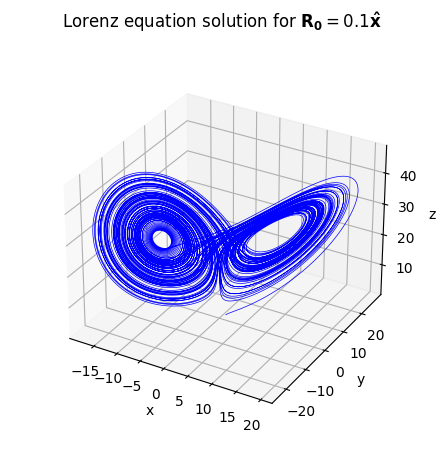

In [130]:
#example simulation
t1, R1 = simulateLorenz(np.array([1,1,1]))
xyzR1List = transformToXYZ(R1)

#graph
ax1 = plt.axes(projection='3d')
ax1.plot3D(xyzR1List[0], xyzR1List[1], xyzR1List[2], 'blue',linewidth = '.5')
ax1.set_zlabel("z")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_box_aspect(None, zoom=0.85)
ax1.set_title(r'Lorenz equation solution for $\mathbf{R_0}=0.1\mathbf{\hat{x}}$')
plt.tight_layout()
plt.show()

Deviation of intially close trajectories

In [131]:
#finds another simulation with close intial condition
delta = 10**(-6)
t2,R2 = simulateLorenz(np.array([1+delta,1,1]))

#finds deviation between 2 trajectories over time
deviationList = [np.linalg.norm(R1[i][2]-R2[i][2]) for i in range(len(R1))]

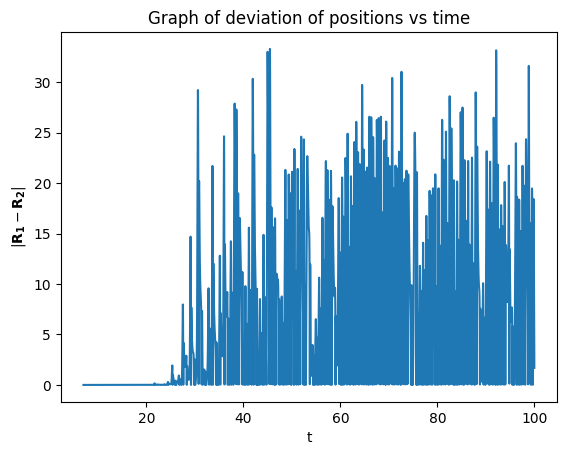

In [132]:

#plots deviation, taking into account the time taken to get to butterfly

deviationList = deviationList[7000:]
T = t1[7000:]

plt.plot(T,deviationList)
plt.xlabel("t")
plt.ylabel(r'$|\mathbf{R_1} - \mathbf{R_2}|$')
plt.title("Graph of deviation of positions vs time")
plt.show() 


Calculation of Liapunov exponent

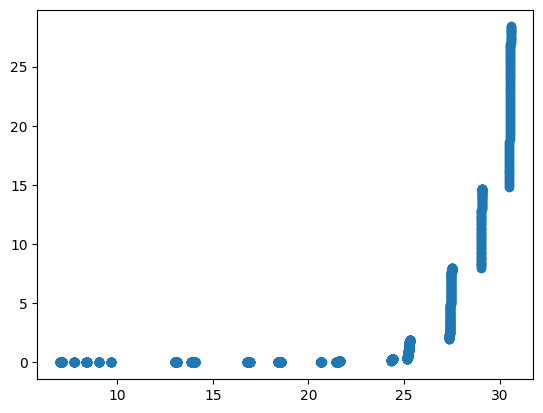

In [161]:
tDevMaxLst = []
RDevMaxLst = []


gMax = 0
for i,d in enumerate(deviationList):
    if d > gMax:
        gMax = d
        tDevMaxLst.append(T[i])
        RDevMaxLst.append(d)



#clear that 35 on bit skews data, as we are looking for growth (very simple model)
#plt.scatter(tDevMaxLst,RDevMaxLst)
#plt.show()

tAdj = tDevMaxLst[:1700]
rAdj = RDevMaxLst[:1700]


plt.scatter(tAdj,rAdj)


In [162]:
m,c = np.linalg.lstsq(np.vstack([tAdj,np.ones(len(tAdj))]).T,np.log(rAdj),rcond=None)[0]
print(m)
#gives the rough expected order

0.7903268403595765


Predictive chaos structure

In [9]:
#niave way to find local maxima
def maxima(i,lst):
    if i == 0 or i == 1 or i == len(lst) - 1 or i == len(lst):
        return False
    return (lst[i-1]<lst[i]) and (lst[i]>lst[i+1])

s1 = transformToXYZ(simulate([np.array([0.1,0,0])]))[2]
maximaList = [m for i,m in enumerate(s1) if maxima(i,s1)]

z_n = maximaList[:-1]
z_n1 = maximaList[1:]
plt.scatter(z_n,z_n1)
plt.show()


NameError: name 'simulate' is not defined

In [ ]:
# # Use this to generate a large number of simulations (via GPUs?) then try and get dim via averages
# num = 2
# evenList = []
# for x in np.linspace(-.5,.5,num):
#     for y in np.linspace(-.5,.5,num):
#         for z in np.linspace(-.5,.5,num):
#             evenList.append(np.array([x,y,z]))

# statesLst = []
# for l in evenList:
#     statesLst += simulate([l])

# print(statesLst)
# def findN(R,lst):
#     n = 0 #should write this more elgantly
#     for pos in lst:
#         if np.linalg.norm(pos)<R:
#             n += 1
#     return n

# R,N = np.linspace(0,20,40),np.linspace(0,20,40) #naming here is bad
# for i,r in enumerate(R):
#     N[i] = findN(r,statesLst)

# plt.plot(R ,np.log(N))
# plt.show()

# #use method of least squares to deduce dimention
# m,c = np.linalg.lstsq(np.vstack([R,np.ones(len(R))]).T,np.log(N),rcond=None)[0]
# print(m)
# print(1/m)
# #may need to remove ends, should use jupyter notebook or store the data somewhereo

# #As there is no preference to different points on the strange attractor I think that this is viable

This part is not done but should sample and try and deduce dimentions

stuff to do:

-try and calculate the dimention

-vary r and look at the r=24.78

-also look at case beforehand (phase protraits may be nice here)

-tidy up and make it clear what I have done and the approximations made

-need to look at error of RK4
